In this notebook I will be going through the various steps in the pipeline to try to understand why it seems that adding
external information by joining new tables does not help with downstream tasks. 



In [1]:
cd ..

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path

import src.pipeline as pipeline
from src._join_aggregator import JoinAggregator
from src.data_structures.loggers import ScenarioLogger
from src.data_structures.metadata import MetadataIndex, RawDataset, CandidateJoin
from src.utils.indexing import write_candidates_on_file
from src.utils.joining import execute_join, aggregate_table
from src.methods.evaluation import evaluate_single_table


In [4]:
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(20)

polars.config.Config

In [6]:
# Select the yadl version
yadl_version = "wordnet_cp_big_fx"
# yadl_version = "open_data"

# Prepare the metadata
metadata_dir = Path(f"data/metadata/{yadl_version}")
metadata_index_path = Path(f"data/metadata/_mdi/md_index_{yadl_version}.pickle")
mdata_index = MetadataIndex(index_path=metadata_index_path)

# Prepare the index dir
index_dir = Path(f"data/metadata/_indices/{yadl_version}")

# Prepare the query table
query_tab_path = Path("data/source_tables/company-employees-yadl.parquet")

base_table = pl.read_parquet(query_tab_path)
print(base_table.columns)
tab_name = query_tab_path.stem



['name', 'domain', 'year founded', 'industry', 'size range', 'locality', 'country', 'linkedin url', 'col_to_embed', 'target']


In [7]:
base_table.groupby("col_to_embed").count()

col_to_embed,count
str,u32
"""<Talbots>""",1
"""<ARUP_Laboratories>""",1
"""<Comcast>""",1
"""<Aspect_Software>""",1
"""<Providence_College>""",1
"""<Primetals_Technologies>""",1
"""<Bacardi>""",1
"""<Arvest_Bank>""",1
"""<South32>""",1


In [8]:
base_table.columns

['name',
 'domain',
 'year founded',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url',
 'col_to_embed',
 'target']

In [9]:
run_label, best_estimator, best_result = evaluate_single_table(
    base_table,
    "target",
    run_label="base_table",
    iterations=100,
    verbose=0
)
print(f"{best_result:.4f}")

0.7416


### Preparing random split in two

In [58]:
base_table_columns = base_table.columns
base_table_columns.remove("col_to_embed")

In [24]:
base_table_columns

['County', 'target']

In [10]:
first_split = list(np.random.choice(base_table_columns, size=len(base_table_columns)//2, replace=False))
second_split = [_ for _ in base_table_columns if _ not in first_split]


In [11]:
print(first_split, second_split)

['Sunrise_Sunset', 'Visibility(mi)', 'Code', 'target', 'Weather_Condition', 'Airport_Code'] ['County', 'Severity', 'Zipcode', 'Country', 'Civil_Twilight', 'State']


In [12]:
first_split.append("col_to_embed")
second_split.append("col_to_embed")
left_table = base_table.select(
    pl.col(first_split)
)
right_table = base_table.select(
    pl.col(second_split)
)


In [13]:
on=left_on=right_on="col_to_embed"
aggr_right = aggregate_table(
    right_table, right_on, aggregation_method="mean"
)

merged_table = execute_join(
    left_table,
    right_table,
    on="col_to_embed"
)

In [14]:
run_label, best_estimator, best_result = evaluate_single_table(
    merged_table,
    "target",
    run_label="split_merge",
    iterations=100,
    verbose=0
)
print(f"{best_result:.2f}")

0.74


### Split table over all columns

In [15]:
col_combinations = []
for col in base_table.drop(["target", "col_to_embed"]).columns:
    col_combinations.append([col, "col_to_embed"])
col_combinations.append(["target", "col_to_embed"])

In [16]:
for col_c in col_combinations:
    if "target" not in col_c:
        test_table = base_table.select(pl.col(col_c), pl.col("target"))
        run_label, best_estimator, best_result = evaluate_single_table(
            test_table,
            "target",
            run_label="split_merge",
            iterations=100,
            verbose=0
        )
        print(f"{col_c} : {best_result:.2f}")

['County', 'col_to_embed'] : 0.28
['Code', 'col_to_embed'] : 0.35
['Severity', 'col_to_embed'] : 0.57
['Zipcode', 'col_to_embed'] : -0.00
['Country', 'col_to_embed'] : -0.00
['Airport_Code', 'col_to_embed'] : 0.27
['Visibility(mi)', 'col_to_embed'] : 0.53
['Weather_Condition', 'col_to_embed'] : -0.00
['Sunrise_Sunset', 'col_to_embed'] : 0.04
['Civil_Twilight', 'col_to_embed'] : 0.06
['State', 'col_to_embed'] : 0.35


### Execute full join

In [17]:
merged = base_table.select(["col_to_embed", "target"])
for col_c in col_combinations:
    if "target" not in col_c:
        right_table = base_table.select(col_c)
        on=left_on=right_on=["col_to_embed"]
        aggr_right = aggregate_table(
        right_table, right_on, aggregation_method="mean"
    )
        merged = execute_join(
            merged,
            aggr_right,
            left_on=left_on,
            right_on=right_on,
            how="left",
        )


In [18]:
run_label, best_estimator, best_result = evaluate_single_table(
    merged,
    "target",
    run_label="full_join",
    iterations=100,
    verbose=0
)
print(f"{best_result:.2f}")

0.74


In [19]:
importances = pl.DataFrame(list(zip(best_estimator.feature_names_, best_estimator.feature_importances_)), schema=["feature_name", "feature_importance"])

In [20]:
i_pd = importances.sort("feature_importance").select(
    pl.col("feature_name"),
    pl.col('feature_importance').cumsum(),
).to_pandas()

In [21]:
seed_ = base_table.select(
    pl.col(["col_to_embed", "target"])
)

In [22]:
merged = seed_.clone()
for r in importances.sort("feature_importance", descending=False).iter_rows():
    col, imp = r
    if col == "col_to_embed":
        continue
    comb = ("col_to_embed", col)
    right_table = base_table.select(comb)
    on=left_on=right_on=["col_to_embed"]
    aggr_right = aggregate_table(
    right_table, right_on, aggregation_method="mean"
    )
    merged = execute_join(
        merged,
        aggr_right,
        left_on=left_on,
        right_on=right_on,
        how="left",
    )
    run_label, best_estimator, best_result = evaluate_single_table(
    merged,
    "target",
    run_label="full_join",
    iterations=100,
    verbose=0
    )
    print(f"{comb} | {best_result:.2f}")

('col_to_embed', 'Zipcode') | -0.00
('col_to_embed', 'Country') | -0.00
('col_to_embed', 'Weather_Condition') | -0.00
('col_to_embed', 'Airport_Code') | 0.27
('col_to_embed', 'County') | 0.29
('col_to_embed', 'Civil_Twilight') | 0.33
('col_to_embed', 'Sunrise_Sunset') | 0.33
('col_to_embed', 'State') | 0.44
('col_to_embed', 'Code') | 0.43
('col_to_embed', 'Severity') | 0.66
('col_to_embed', 'Visibility(mi)') | 0.74


### Adding a fake "class" column

In [23]:
base_table_aug = base_table.with_columns(
    pl.when(pl.col("target") > 1.5).then(1).otherwise(0).alias("class")
)

In [24]:
run_label, best_estimator, best_result = evaluate_single_table(
    base_table_aug,
    "target",
    run_label="split_merge",
    iterations=100,
    verbose=0
)
print(f"{best_result:.2f}")

0.81


# Manually evaluating join candidates

### Querying index

In [10]:
top_k = 50
selected_index = "minhash"
index_path = Path(index_dir, selected_index + "_index.pickle")
minhash_index = pipeline.load_index(index_path, tab_name)

query_tab_metadata = RawDataset(
    query_tab_path.resolve(), "queries", "data/metadata/queries"
)
query_tab_metadata.save_metadata_to_json()
query_column = "col_to_embed"
query = base_table[query_column].drop_nulls()
query_results = minhash_index.query_index(query)
candidates = pipeline.generate_candidates(
    "minhash",
    query_results,
    mdata_index,
    query_tab_metadata.metadata,
    query_column,
    top_k,
)


In [11]:
k, candidate_join = next(iter(candidates.items())) 

In [12]:
src_md, cnd_md, left_on, right_on = candidate_join.get_join_information()
src_df = pl.read_parquet(src_md["full_path"])
cnd_df = pl.read_parquet(cnd_md["full_path"])
cols_to_agg = [col for col in cnd_df.columns if col not in right_on]


In [13]:
cols_to_agg

['type', 'hasWonPrize', 'hasLongitude']

In [14]:
def get_importances(model, left_col, right_col, key_col):
    k_d = {col: 0 for col in key_col}
    l_d = {col: 1 for col in left_col}
    r_d = {col: 2 for col in right_col}
    d = dict(**k_d, **l_d, **r_d)

    importances = pl.DataFrame(
        list(
            zip(model.feature_names_, 
                model.feature_importances_)), 
        schema=["feature_name", "feature_importance"]
    )
    return importances.with_columns(
            pl.col("feature_name").alias("source").map_dict(d)
        )

def get_fraction_missing(table, col_subset):
    return table.select(
        (pl.col(col_subset).is_null().sum()/len(table))
    ).mean(axis=1).item() 
   
def get_imp_frac(imp):
    return imp.melt(id_vars="source", value_vars="feature_importance").pivot(
    index="variable",
    values="value",
    columns="source",
    aggregate_function="mean"
).select(
    pl.col("0").alias("imp_key"),
    pl.col("1").alias("imp_left"),
    pl.col("2").alias("imp_right")
).to_dicts()[0]

In [15]:
results = []
run_label, best_estimator, best_result = evaluate_single_table(
    base_table,
    "target",
    run_label="base_table",
    iterations=100,
    verbose=0
)

base_result = best_result
print(base_result)
left_col = [col for col in base_table.columns]

imp = get_importances(best_estimator, left_col, [], [])
frac_imp = {
    "imp_key": 0,
    "imp_left": 1,
    "imp_right": 0
}
r_dict = {
        "df_name": "base_table",
        "r2": best_result,
        "frac_null": 0,

    }

r_dict.update(frac_imp)
results.append(r_dict)


0.7415841942123096


In [16]:
for idx,(k, candidate_join) in enumerate(candidates.items()):
    src_md, cnd_md, left_on, right_on = candidate_join.get_join_information()
    src_df = pl.read_parquet(src_md["full_path"])
    cnd_df = pl.read_parquet(cnd_md["full_path"])

    
    aggr_right = aggregate_table(
    cnd_df, right_on, aggregation_method="mean"
    )
    merged = execute_join(
        base_table,
        aggr_right,
        left_on=left_on,
        right_on=right_on,
        how="left",
        suffix="_right"
    )
    left_col = [col for col in base_table.columns if col not in left_on]
    key_col = left_on
    right_col = [col for col in merged.columns if col not in (left_col + left_on)]
    
    run_label, best_estimator, best_result = evaluate_single_table(
    merged,
    "target",
    run_label="full_join",
    iterations=100,
    verbose=0
    )
    print(f"{idx+1:>3}/{len(candidates)} : {best_result:.4f}")
    imp = get_importances(best_estimator, left_col, right_col, key_col)
    try:
        frac_imp = get_imp_frac(imp)
        frac_null = get_fraction_missing(merged, right_col)
    except Exception:
        continue
    r_dict = {
        "df_name": cnd_md["df_name"],
        "r2": best_result,
        "frac_null": frac_null,
        "n_left_col": len(left_col),
        "n_right_col": len(right_col),
        "n_key_col": len(key_col),
    }
    r_dict.update(frac_imp)
    results.append(r_dict)

df_results = pl.from_dicts(results, )

  1/50 : 0.7432
  2/50 : 0.7428
  3/50 : 0.7519
  4/50 : 0.7398
  5/50 : 0.7391
  6/50 : 0.7515
  7/50 : 0.7399
  8/50 : 0.7429
  9/50 : 0.7422
 10/50 : 0.7518
 11/50 : 0.7398
 12/50 : 0.7416
 13/50 : 0.7437
 14/50 : 0.7398
 15/50 : 0.7398
 16/50 : 0.7398
 17/50 : 0.7416
 18/50 : 0.7399
 19/50 : 0.7429
 20/50 : 0.7398
 21/50 : 0.7411
 22/50 : 0.7416


KeyboardInterrupt: 

In [38]:
df_results = df_results.with_columns(
    ((pl.col("r2")/base_result - 1)*100).alias("difference")
).sort("difference")
df_results

df_name,r2,frac_null,imp_key,imp_left,imp_right,n_left_col,n_right_col,n_key_col,difference
str,f64,f64,f64,f64,f64,i64,i64,i64,f64
"""wordnet_church_isLocatedIn_hasLength""",0.002747,0.998821,45.45002,43.132118,3.805954,2,3,1,-28.725418
"""wordnet_organization_isLocatedIn_hasNumberOfPeople""",0.002891,0.998713,33.656352,55.328057,3.671864,2,3,1,-24.993298
"""wordnet_organization_isLocatedIn_hasLatitude""",0.002977,0.998606,36.862741,53.286621,3.283546,2,3,1,-22.771135
"""wordnet_church_isLocatedIn_hasLatitude""",0.002996,0.998392,35.391875,53.669785,3.646113,2,3,1,-22.257892
"""yagowordnet_cp_wordnet_organization""",0.003078,0.999586,41.620994,48.746065,0.688067,2,14,1,-20.135616
"""wordnet_conflict_happenedOnDate_isLocatedIn""",0.003095,0.998392,48.957083,41.954854,3.029355,2,3,1,-19.705973
"""wordnet_organization_isLocatedIn_isAffiliatedTo""",0.003249,0.998928,36.479313,55.069361,2.817108,2,3,1,-15.712117
"""wordnet_organization_hasWonPrize_isLocatedIn""",0.003249,0.998928,36.479313,55.069361,2.817108,2,3,1,-15.712117
"""wordnet_organization_isLocatedIn_hasMotto""",0.003249,0.998928,36.479313,55.069361,2.817108,2,3,1,-15.712117


In [58]:
df_results.select(
    pl.corr("r2", "imp_right").alias("corr_imp_right"),
    pl.corr("r2", "frac_null").alias("corr_frac_null"),
)

corr_imp_right,corr_frac_null
f64,f64
-0.386333,0.078262


In [ ]:
df_results.with_columns(
    ((pl.col("r2")/base_result - 1)*100).alias("difference")
).sort("difference")

df_name,r2,frac_null,imp_key,imp_left,imp_right,n_left_col,n_right_col,n_key_col,difference
str,f64,f64,f64,f64,f64,i64,i64,i64,f64
"""hbwp-wys3""",0.505717,0.796368,0.0,98.385657,1.614343,3,7,1,-9.275708
"""wjtw-p6gu""",0.506952,0.81642,0.0,99.122649,0.877351,3,16,1,-9.05424
"""4phz-5afm""",0.50696,0.807327,0.0,97.654269,2.345731,3,4,1,-9.052749
"""uy57-3u8f""",0.507312,0.888154,0.0,99.2986,0.7014,3,3,1,-8.989568
"""5ndz-hdpi""",0.507658,0.947428,0.0,98.912927,1.087073,3,30,1,-8.927455
"""p39g-siwr""",0.508709,0.79964,0.0,96.409197,3.590803,3,4,1,-8.7389
"""dzyk-hhe6""",0.509221,0.97403,0.0,99.407491,0.592509,3,17,1,-8.647041
"""7ix4-a8g6""",0.509235,0.888154,0.0,99.105936,0.894064,3,2,1,-8.644686
"""tqti-3w6t""",0.50925,0.917691,0.0,99.258352,0.741648,3,7,1,-8.641838


In [40]:

left_col = [col for col in base_table.columns if col not in left_on]
right_col = [col for col in target.columns if col not in right_on]
key_col = left_on

aggr_right = aggregate_table(
target, right_on, aggregation_method="mean"
)
merged = execute_join(
    base_table,
    aggr_right,
    left_on=left_on,
    right_on=right_on,
    how="left",
)

run_label, best_estimator, best_result = evaluate_single_table(
merged,
"target",
run_label="full_join",
iterations=100,
verbose=0
)
print(best_result)
imp = get_importances(best_estimator, left_col, right_col, key_col)


NameError: name 'target' is not defined

In [67]:
imp.groupby("source").agg(
    pl.sum("feature_importance")
)

source,feature_importance
i64,f64
0,5.615749
1,91.334566
2,3.049685


In [90]:
imp

feature_name,feature_importance,source
str,f64,i64
"""col_to_embed""",36.553675,1
"""county_name""",0.0,0
"""party""",61.699804,1
"""local_education_agency_lea""",0.043022,2
"""lea_type""",0.038553,2
"""school_name""",0.000195,2
"""administrative_unit_number_aun""",0.120865,2
"""county_code""",0.153815,2
"""school_number""",0.084684,2


In [ ]:
df_results.select(pl.corr("r2", "frac_null"))

r2
f64
0.783251


### Plot importances

In [ ]:
cmap = {
    0: "red",
    1: "blue",
    2: "green"
}

i_df = imp.with_columns(
    pl.col("feature_name").alias("source").map_dict(d)
).to_pandas()
i_df["color"] = i_df["source"].map(cmap)

NameError: name 'd' is not defined

<BarContainer object of 15 artists>

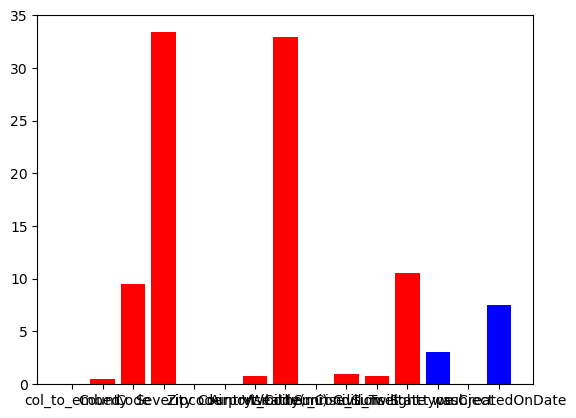

In [ ]:
plt.bar(data=i_df, x="feature_name", height="feature_importance", color=i_df["color"])